In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical  
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, GlobalAveragePooling2D, ZeroPadding2D, add, Concatenate

## Generate a Dataset

In [2]:
seq_len = 25
num_samples  = 80000

In [3]:
def integration_task(seq_len, num_samples):
    for _ in range(num_samples):
        noise = np.random.normal(size=(seq_len, 1))
        sum = tf.math.reduce_sum(noise)
        target = np.expand_dims(tf.cast(sum>1, tf.int16), axis=-1)
        yield noise, target

In [4]:
def my_integration_task(seq_len = seq_len, num_samples = num_samples):
    for noise, target in integration_task(seq_len, num_samples):
        yield noise, target

In [5]:
ds = tf.data.Dataset.from_generator(my_integration_task, output_signature=(tf.TensorSpec(shape=(seq_len, 1), dtype=tf.float32),
                                                                          tf.TensorSpec(shape=(1), dtype=tf.int16)))

2022-01-14 22:30:47.585189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Split and Preprocess the Dataset

In [6]:
train_size = int(0.8 * num_samples)
test_size = int(0.2 * num_samples)

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size) 

In [7]:
train_size, test_size

(64000, 16000)

In [8]:
def preprocessing(ds):
    ds = ds.cache()
    ds = ds.shuffle(1500)
    ds = ds.batch(500)
    ds = ds.prefetch(100)
    return ds

In [9]:
train_ds = train_ds.apply(preprocessing)
test_ds = test_ds.apply(preprocessing)

## The LSTM Cell Class

In [10]:
class LSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTMCell, self).__init__()
        self.units = units
        self.forget_layer = Dense(units, activation="sigmoid", bias_initializer = "ones")

        # what elements should be changed in the input to be added to the cell state
        self.input_gate=  Dense(units, activation="sigmoid")

        self.output_gate = Dense(units, activation="sigmoid")
        self.hidden_state = Dense(units, activation="tanh")

        self.previous_hidden_state, self.previous_cell_state = None, None


    def call(self, inputs, hidden_cell_states):
        batch_size = inputs[0]

        if not hidden_cell_states:
            # the first time we need to initialize the vector
            self.previous_hidden_state = tf.zeros((batch_size, self.cell.units))
            self.previous_cell_state = tf.zeros((batch_size, self.cell.units))

        else:
            self.previous_hidden_state, self.previous_cell_state = hidden_cell_states
            
        concatenated_vector = tf.keras.concatenate([inputs, self.previous_hidden_state], axis = 1)

        input_lstm_cell = concatenated_vector

        forget_layer_output = self.forget_layer(input_lstm_cell)

        if self.previous_cell_state:
            self.current_cell_state = tf.math.multiply(forget_layer_output, self.previous_cell_state)
        else:
            self.current_cell_state = forget_layer_output

        ## add new information
        input_gate_output = self.input_gate(input_lstm_cell)
        
        new_information = tf.math.multiply(input_gate_output, input_gate_output)

        self.current_cell_state += new_information

        output = tf.math.multiply(self.output_gate(input_lstm_cell), tf.nn.tanh(self.current_cell_state))

        ## update the cell state and the hidden state for the next time step
        self.previous_cell_state = self.current_cell_state
        self.previous_hidden_state = output

        return self.previous_hidden_state, self.previous_cell_state 

## LSTM Layer Class

In [22]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTMLayer, self).__init__()
        self.LSTM_cell = LSTMCell(units)

    # with tf.device('/device:cpu:0'):
    @tf.function
    def call(self, x, states=None): 
        # initialize the hidden_states TensorArray that we want to output (shape: batch, time-steps, h_dim)
        output_sequence = tf.TensorArray(dtype=tf.float32, size = 0, dynamic_size=True)
        for t in tf.range(x.shape[1]):
            input_t = x[:,t]
            output = self.LSTM_cell(input_t, states)
            # write the states to the TensorArray
            output_sequence = output_sequence.write(t, output)
            
        # transpose the sequence of hidden_states from TensorArray accordingly (batch and time dimensions switched)
        outputs = tf.transpose(output_sequence.stack(), perm=[1,0,2])
        return outputs
    

## The Final Model Class

In [20]:
class Model(tf.keras.Model):
    def __init__(self, layers_list, loss_function, optimizer= None):
        super(Model, self).__init__()
        self.layers_list = layers_list
        self.output_layer = Dense(1, activation='sigmoid')
        self.loss_function = loss_function
        self.optimizer = optimizer
    
    def call(self, input_0):
        input_t = input_0
        for layer in self.layers_list:
            input_t = layer(input_t)

        return self.output_layer(inputs)[:,-1,:]
    
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target) == np.round(prediction)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target) == np.round(prediction)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

In [23]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 6
LEARNING_RATE = 0.001

# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize the model
model = Model([Dense(40, activation="relu"),
                    LSTMLayer(units=10)], 
                    loss_function = cross_entropy_loss, optimizer = optimizer)

# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Testing models performance before training starts.
# Test-Dataset
test_loss, test_accuracy = model.test(test_ds)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
# Train-Dataset
train_loss, train_accuracy = model.test(train_ds)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input, target in train_ds:
        train_loss, train_accuracy = model.train(input, target)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    # track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
    # track loss and accuracy for test-dataset
    test_loss, test_accuracy = model.test(test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

2022-01-14 22:46:16.709436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1500
2022-01-14 22:46:16.710276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1500
2022-01-14 22:46:17.282968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-01-14 22:46:17.587150: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: in user code:

    /var/folders/54/062pxv157md83zzypl6cr61mmh0r_v/T/ipykernel_83345/2543544594.py:13 call  *
        output = self.LSTM_cell(input_t, states)
    /var/folders/54/062pxv157md83zzypl6cr61mmh0r_v/T/ipykernel_83345/1842353203.py:17 call  *
        self.previous_hidden_state, self.previous_cell_state = hidden_cell_states

    TypeError: cannot unpack non-iterable NoneType object


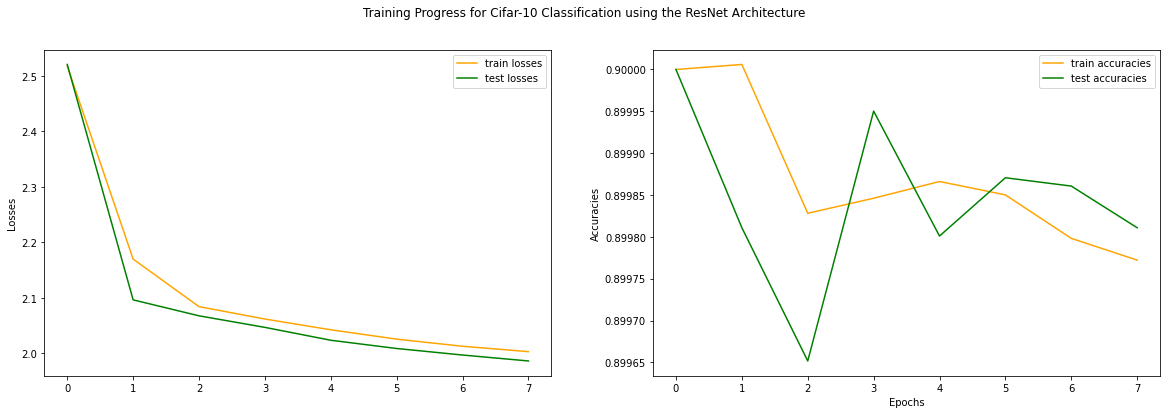

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training using the LSTM Layers')
axs[0].plot(train_losses, color='orange', label='train losses')
axs[0].plot(test_losses, color='green', label='test losses')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(train_accuracies, color='orange', label='train accuracies')
axs[1].plot(test_accuracies, color='green', label='test accuracies')

axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()